# Linear Frequency Adjustment for Repetitive Line Patterns

This notebook explores how to detect and refine **dominant Fourier frequencies** that correspond to repetitive linear patterns (e.g., parallel line structures) in small images.
We: (1) analyze the quality of frequency proposals, (2) build datasets that pair images, frequency proposals, and quality scores, and (3) train a probability model that predicts how good a proposed frequency is for a given line pattern.

## 1. Environment and Core Dependencies

This section loads all required libraries and project utilities for frequency-domain analysis and line-pattern generation:

- **TensorFlow / Keras / TFP**: modeling, losses, and attention blocks.
- **Custom `models_src.*` modules**: Fourier line generators, frequency proposal extraction, attention, metrics, and dataset utilities.
- **Visualization stack**: matplotlib, seaborn, OpenCV for inspecting masks, frequency maps, and evaluation plots.

These components form the base for experimenting with linear patterns in the Fourier domain.

In [ ]:
import os
import sys
sys.path.append(os.path.abspath("../"))

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd

import math
import seaborn as sns
import cv2 as cv
from src.utils import reload_script
import warnings

#reload_script('models_src.Hough')

from models_src.Hough import FreqLinesGenerator, VecDrawer, freq_decoder, FreqShiftOptimization, GaussianMixtureComponents, TopKFreqs, F1
from models_src.fft_lib import xy_coords, FFT2D, amp_and_phase, top_k2D
from models_src.Attn_variations import UnSqueezeImg, SqueezeImg, ExtractPatches, ConcatenatePatches
from models_src.DETR import FFN, MHA, HeadsPermuter
from models_src.Metrics import WeightedF12D
from models_src.Support import LRCallback, DatasetGenerator
%matplotlib inline

2024-04-22 09:34:12.125112: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 09:34:12.153295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 09:34:12.376937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 09:34:12.378575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 09:34:13.449947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

### 1.1 Reloading Support Utilities

This cell ensures that the latest version of **dataset and training support utilities** is used. It is useful when iterating quickly on dataset logic for linear-pattern experiments.

In [117]:
reload_script('models_src.Support')
from models_src.Support import LRCallback, DatasetGenerator

## 2. Single-Frequency Adjustment Overview

We study **how well individual Fourier frequencies explain repetitive linear patterns** in small patches.
The goal is to learn a model that can score or select the best candidate frequency (direction + magnitude + phase) for each pattern, improving downstream line detection.

## 3. Frequency-Loss Distribution Analysis

In this section we quantify how **frequency proposals** relate to line-detection quality:

1. Generate synthetic images with repetitive line patterns and their ground-truth frequencies.
2. Extract candidate frequencies from masks using `TopKFreqs`.
3. Compute a composite **frequency loss** (freq, angle, phase) and F1 scores for the detection model.
4. Visualize the distribution of these scores to understand which proposals are most useful.

### 3.1 Positional Encoding, Attention Encoder, and Frequency Loss

These utilities support the analysis of linear patterns:

- **Positional encoding & `AddPosEnc`**: inject spatial structure into feature sequences derived from frequency patches.
- **`EncoderLayer`**: a Transformer-style block combining multi-head attention and feed-forward layers, later reused in the probability model.
- **`FreqLoss`**: decomposes frequency quality into three interpretable terms: 
  - frequency magnitude error,
  - orientation (angle) error,
  - phase alignment error.
These components let us reason about how each aspect affects recognition of repetitive linear structures.

In [3]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

class AddPosEnc(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.pos_enc = positional_encoding(input_shape[-2], input_shape[-1])[tf.newaxis]

    def call(self, inputs):
        return inputs+self.pos_enc    

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, 
                 attn_dim=512, 
                 key_dim=512, 
                 num_heads=4, 
                 dropout=0.0,
                 FFN_mid_layers=1, 
                 FFN_mid_units=2048,
                 FFN_activation='relu',
                 **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)

        self.attn_dropout, self.output_dropout = [tf.keras.layers.Dropout(dropout) for _ in range(2)]
        self.attn_addnorm, self.output_addnorm = [tf.keras.Sequential([
            tf.keras.layers.Add(),
            tf.keras.layers.LayerNormalization(axis=-2)])
            for _ in range(2)]

        self.FFN = FFN(FFN_mid_layers, FFN_mid_units, attn_dim, dropout, FFN_activation)

        self.MHA = MHA(attn_dim, attn_dim, key_dim, num_heads)

    def call(self, V, Q=None, K=None, training=None):

        if Q is None:
            Q = V

        if K is None:
            K = V

        # Multi-Head-Attention
        V = self.attn_addnorm([V, self.attn_dropout(self.MHA(V, Q, K), training=training)])

        # Feed-Forward-Network
        V = self.output_addnorm([V, self.output_dropout(self.FFN(V), training=training)])

        return V

In [4]:
class FreqScoresDataset():
    def __init__(self, 
                 flg, 
                 batch_size, 
                 examples_num, 
                 min_width=0.2, 
                 min_lines_num=2, 
                 parallel_calls=4, 
                 size=32, 
                 color_rand_range=0.2,
                 cl_rand_range=0.1):

        self.flg = flg
        self.batch_size = batch_size
        self.examples_num = examples_num
        self.vd = VecDrawer(min_width=min_width, min_num=min_lines_num)
        self.parallel_calls = parallel_calls
        self.size = size

        self.color_range = color_rand_range
        self.cl_range = cl_rand_range

    def _gen_parameters(self, *args):
        Xuv, phase = self.flg.random_freqs(examples_num=self.examples_num)
        vecs_col, lengths, lines_mask, vecs_slope, vecs_bias, Iuvx, vec_angle = self.flg.gen_vecs(Xuv, phase)
        Iuvx = tf.concat([Iuvx, tf.ones((1,self.size, self.size))], axis=0)
        Xuv = tf.concat([Xuv, tf.zeros((1,2))], axis=0)
        phase = tf.concat([phase, tf.zeros((1,1))], axis=0)
        return Xuv, vecs_col, lengths, lines_mask, vec_angle, phase, Iuvx
    
    def _map_drawing(self, Xuv, vecs_col, lengths, lines_mask, vec_angle, phase, Iuvx):
        I, masks, _, _, colors = tf.py_function(self.vd.draw_vecs, [vecs_col, lines_mask, lengths], [tf.float32, tf.float32, tf.float32, tf.float32, tf.float32])
        I.set_shape((self.size,self.size,3))
        colors = tf.clip_by_value(colors+tf.random.uniform((self.examples_num+1,3), -self.cl_range, self.cl_range), 0., 1.)
        I = 1-tf.abs(tf.clip_by_value(I[tf.newaxis]+tf.random.uniform((self.examples_num+1,self.size, self.size, 3), -self.color_range, self.color_range), 0.0, 1.0)-colors[:,tf.newaxis, tf.newaxis])
        
        return I,Xuv, phase, masks
    
    def gen_full_map(self):
        args = self._gen_parameters()
        features = self._map_drawing(*args)
        return features
    
    def reload_parcel_inputs(self):
        None
    
    def new_dataset(self):
        ds = tf.data.Dataset.range(self.batch_size*2)
        ds = ds.map(self._gen_parameters, num_parallel_calls=self.parallel_calls)
        ds = ds.map(self._map_drawing, num_parallel_calls=self.parallel_calls)
        ds = ds.batch(self.batch_size)
        ds = ds.repeat()

        return ds

In [ ]:
class FreqLoss(tf.keras.losses.Loss):
    def __init__(self, name='FL', freq_weight=0.35, angle_weight=0.35, phase_weight=0.3, reduction=tf.keras.losses.Reduction.AUTO, **kwargs):
        super().__init__(name=name, reduction=reduction, **kwargs)

        self.weights = tf.constant([[freq_weight, angle_weight, phase_weight]], tf.float32)
        self.weights /= tf.reduce_sum(self.weights, axis=-1, keepdims=True)

    @staticmethod
    def calc_angle(Xuv):
        vecx, vecy = tf.split((Xuv), 2, axis=-1)

        vec_angle = tf.math.atan2(vecy,vecx)
        return vec_angle

    @staticmethod
    def angle_loss(true_angle, pred_angle):
        return tf.abs(tf.sin(true_angle-pred_angle))

    @staticmethod
    def freq_loss(true_freq, pred_freq):
        return tf.reduce_sum(tf.abs(tf.abs(true_freq)-tf.abs(pred_freq)), axis=-1, keepdims=True)/2
    
    def extract_components(self, y):
        Xuv, phase = tf.split(y, [2,1], axis=-1)
        angle = self.calc_angle(Xuv)

        return Xuv, angle, phase*math.pi
    
    def calc_losses(self, y_true, y_pred):
        true_Xuv, true_angle, true_phase = self.extract_components(y_true)
        pred_Xuv, pred_angle, pred_phase = self.extract_components(y_pred)

        freq_loss = self.freq_loss(true_Xuv, pred_Xuv)
        angle_loss = self.angle_loss(true_angle, pred_angle)
        phase_loss = 1-self.angle_loss(true_phase, pred_phase)

        return freq_loss, angle_loss, phase_loss
    
    def call(self, y_true, y_pred):
        
        freq_loss, angle_loss, phase_loss = self.calc_losses(y_true, y_pred)
        loss = tf.reduce_sum(tf.concat([freq_loss, angle_loss, phase_loss], axis=-1)*self.weights, axis=-1)

        return loss

### 3.2 Loading the Pretrained Line-Detection Model

We load a pretrained **line-detection network** (`lines_detection_v7_freqposenc.h5`).
This model produces binary masks highlighting line structures; its F1 score serves as a proxy for how well a proposed frequency explains the observed pattern.

In [ ]:
detection_model = tf.keras.models.load_model('./saved/lines_detection_v7_freqposenc.h5', custom_objects={'WeightedF12D': WeightedF12D, 
                                                                          'FFN': FFN, 
                                                                          'ExtractPatches': ExtractPatches,
                                                                          'ConcatenatePatches': ConcatenatePatches,
                                                                          'EncoderLayer': EncoderLayer,
                                                                          'AddPosEnc': AddPosEnc})

### 3.3 Visualizing Frequency vs. Detection Quality

The following cells:
- Run many synthetic samples through the detection model,
- Compare **ground-truth vs. proposed frequencies**,
- Compute F1 scores and per-component frequency scores (freq, angle, phase),
- Plot distributions and scatter plots.

These plots reveal which aspects of the frequency (magnitude, direction, phase) are most critical for successful repetitive-line recognition.

In [90]:
pred_scores_col = []
prop_scores_col = []
partial_scores_col = []
k=3

n=50
pb = tf.keras.utils.Progbar(n)
for i in range(n):
    features = next(iter(ds))
    I,Xuv, phase, masks = [a[:,:-1] for a in features]
    I = tf.reshape(I, (-1,32,32,3))
    Xuv = tf.reshape(Xuv, (-1,2))
    phase = tf.reshape(phase, (-1,1))
    masks = tf.reshape(masks, (-1, 32, 32,1))

    pred_phases, pred_Xuv, pred_Iuvx = TopKFreqs(freq_filter_size=0, pool_size=3, top_k=k, size=32)(masks)
    I = tf.reshape(tf.repeat(I[:,tf.newaxis], k, axis=1), (-1,32,32,3))
    Xuv = tf.reshape(tf.repeat(Xuv[:,tf.newaxis], k, axis=1), (-1,2))
    phase = tf.reshape(tf.repeat(phase[:,tf.newaxis], k, axis=1), (-1,1))
    masks = tf.reshape(tf.repeat(masks[:,tf.newaxis], k, axis=1)[...,0], (-1,32**2))

    pred_Iuvx = tf.reshape(pred_Iuvx, (-1,32,32,1))
    pred_Xuv = tf.reshape(tf.cast(pred_Xuv, tf.float32), (-1,2))
    pred_phases = tf.reshape(pred_phases, (-1,1))

    preds = detection_model([I, pred_Iuvx], training=False)
    preds = tf.reshape(preds, (-1, 32**2))

    pred_scores = F1(masks, preds, axis=-1)

    label_freqs = tf.concat([2*Xuv/32,phase/math.pi], axis=-1)
    prop_freqs = tf.concat([2*pred_Xuv/32,pred_phases/math.pi], axis=-1)
    partial_scores = tf.concat([1-x for x in loss.calc_losses(label_freqs, prop_freqs)], axis=-1)
    prop_scores = 1-loss(label_freqs, prop_freqs)

    pred_scores_col.append(pred_scores)
    prop_scores_col.append(prop_scores)
    partial_scores_col.append(partial_scores)
    pb.add(1)

#print(I.shape, Xuv.shape, phase.shape, masks.shape, top_Iuvx.shape, top_phases.shape, top_coords.shape, preds.shape, scores.shape)
pred_scores_col = tf.concat(pred_scores_col, axis=0)
prop_scores_col = tf.concat(prop_scores_col, axis=0)

partial_scores_col = tf.concat(partial_scores_col, axis=0)
freq_scores, angle_scores, phase_scores = [x[:,0] for x in tf.split(partial_scores_col, 3, axis=-1)]

print(pred_scores_col.shape, prop_scores_col.shape, partial_scores_col.shape)

50/50 [==============================] - 47s 932ms/step
(3600,) (3600,) (3600, 3)


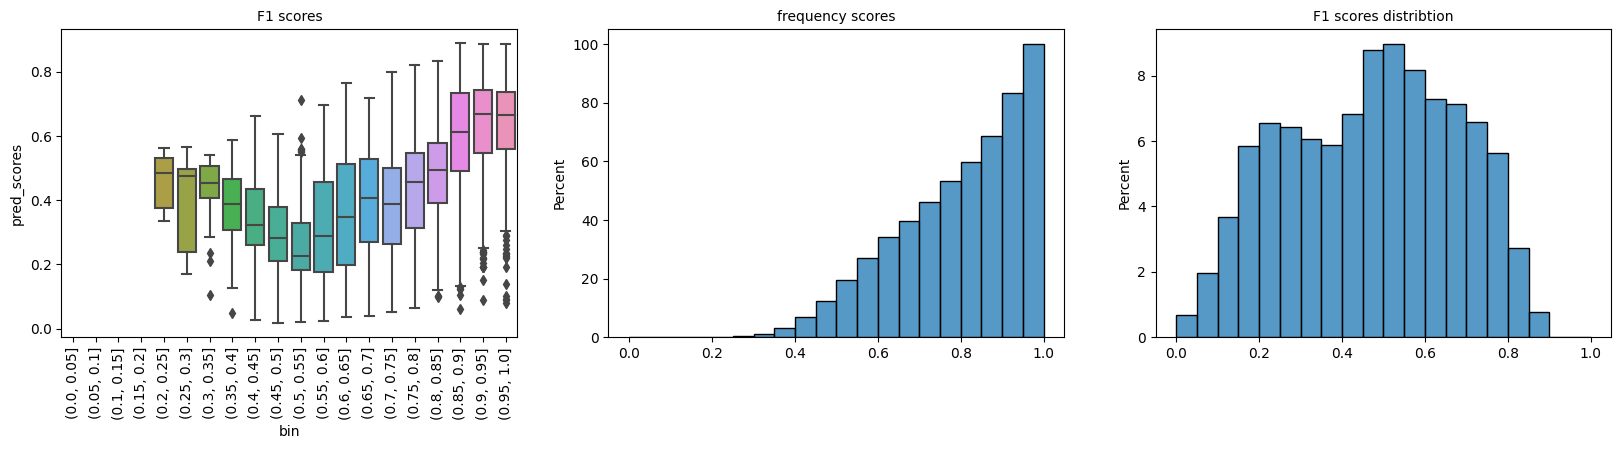

In [ ]:
df = pd.DataFrame({'pred_scores': pred_scores_col.numpy(), 'prop_scores': prop_scores_col.numpy()})
df['bin'] = pd.cut(df['prop_scores'], bins=np.linspace(0,1,21))

fig, axs = plt.subplots(1,3, figsize=(20,4))
sns.boxplot(x='bin', y='pred_scores', data=df, ax=axs[0])
axs[0].tick_params(axis='x', rotation=90)

sns.histplot(prop_scores_col, stat='percent', cumulative=True, bins = np.linspace(0,1,21), ax=axs[1])
sns.histplot(pred_scores_col, stat='percent', bins = np.linspace(0,1,21), ax=axs[2])

axs[0].set_title('F1 scores', fontsize=10)
axs[1].set_title('frequency scores', fontsize=10)
axs[2].set_title('F1 scores distribtion', fontsize=10)

plt.show()

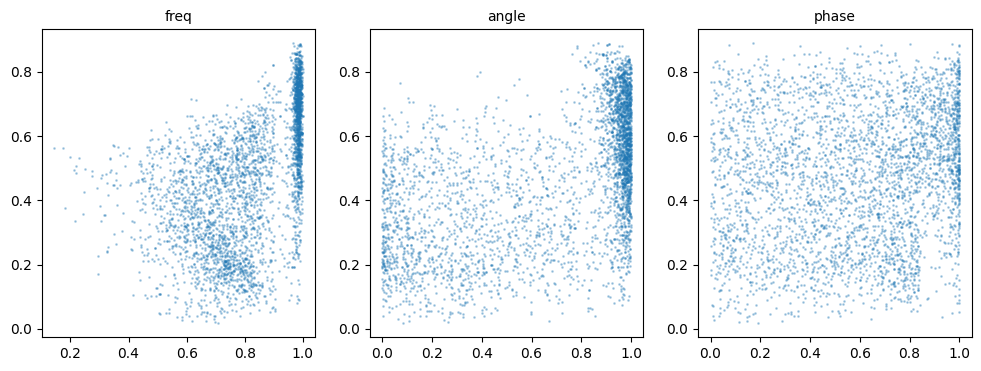

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].scatter(freq_scores, pred_scores_col, alpha=0.3, s=1.)
axs[1].scatter(angle_scores, pred_scores_col, alpha=0.3, s=1.)
axs[2].scatter(phase_scores, pred_scores_col, alpha=0.3, s=1.)

for i, title in enumerate(['freq', 'angle', 'phase']):
    axs[i].set_title(title, fontsize=10)

In [ ]:
features, labels = next(iter(ds))
I, prop_Iuvx, prop_freqs = features
loss_labels, true_mask = labels
print([x.shape for x in features], [x.shape for x in labels])

#true_Iuvx = fd(*tf.split(true_freqs, [2,1], axis=-1))
prop_Iuvx = fd(*tf.split(prop_freqs, [2,1], axis=-1))

s = len(I)
fig, axs = plt.subplots(2, s, figsize=(s*2, 4))

for i in range(s):
    axs[0,i].imshow(I[i])
    axs[1,i].imshow(prop_Iuvx[i])
    axs[0,i].set_title('{:.2f}'.format(loss_labels[i,0]))

In [ ]:
prob_model = tf.keras.models.load_model('./saved/single_freq_adj_binary_v1.h5', custom_objects={'WeightedF12D': WeightedF12D, 
                                                                          'FFN': FFN, 
                                                                          'ExtractPatches': ExtractPatches,
                                                                          'ConcatenatePatches': ConcatenatePatches,
                                                                          'EncoderLayer': EncoderLayer,
                                                                          'AddPosEnc': AddPosEnc,
                                                                          'MHA': MHA})

## 4. Dataset Construction for Frequency Adjustment

We now construct a **supervised dataset** that pairs:

- An input image with repetitive lines,
- A candidate frequency proposal (in normalized Fourier coordinates),
- A scalar label indicating how well the proposal matches the true pattern (derived from `FreqLoss`).

This dataset is later serialized to TFRecords and used to train a model that predicts proposal quality directly from the image and frequency map.

### 4.1 Rendering Frequencies as Spatial Patterns (`FreqDrawer`)

`FreqDrawer` converts a frequency vector (u, v, phase) into a **cosine pattern image**.
This is useful for visualizing and conditioning models on the exact sinusoidal structure implied by the frequency, which directly corresponds to the underlying linear repetition in the spatial domain.

In [7]:
class FreqDrawer():
    def __init__(self, size=32, batch_dims=1, rescale_input=True):

        self.size = 32
        self.xy = xy_coords((size, size))

        for i in range(batch_dims):
            self.xy = tf.expand_dims(self.xy, axis=0)

        self.rescale = rescale_input

    def __call__(self, Xuv, phase):
        
        if self.rescale:
            Xuv = Xuv*self.size/2
            phase = phase*math.pi
            
        angle = self.xy*Xuv[...,tf.newaxis, tf.newaxis,:]/self.size*2*math.pi
        Iuvx = tf.cos(phase[...,tf.newaxis]*math.pi+tf.reduce_sum(angle, axis=-1))

        return Iuvx

### 4.2 `VecDataset`: Sampling Proposals and Labels

`VecDataset` generates examples of the form `((I, I_uvx, prop_freq), label)` where:

- **`I`**: RGB image displaying the line pattern.
- **`I_uvx`**: frequency-domain patch or synthesized cosine pattern associated with a proposal.
- **`prop_freq`**: proposed frequency parameters (normalized).
- **`label`**: similarity score between proposed and ground-truth frequencies (derived from `FreqLoss`).

By sampling different proposals per line pattern, we create rich supervision for learning which frequencies best capture repetitive structure.

In [8]:
class VecDataset():
    def __init__(self, 
                 flg, 
                 batch_size, 
                 examples_num, 
                 min_width=0.2, 
                 min_lines_num=2, 
                 parallel_calls=4, 
                 size=32, 
                 freq_rand_range=1., 
                 phase_rand_range=0.3,
                 color_rand_range=0.2,
                 cl_rand_range=0.1,
                 freq_rand_method='uniform',
                 totally_rand_freq_prob=0.5,
                 freq_weight=0.4,
                 angle_weight=0.4,
                 phase_weight=0.2,
                 loss_threshold=0.95,
                 top_k_freqs=3,
                 freq_filter_size=2,
                 pool_size=3,
                 return_mask=False):

        self.flg = flg
        self.batch_size = batch_size
        self.examples_num = examples_num
        self.vd = VecDrawer(min_width=min_width, min_num=min_lines_num)
        self.parallel_calls = parallel_calls
        self.size = size

        self.freq_range = freq_rand_range
        self.phase_range = phase_rand_range
        self.color_range = color_rand_range
        self.cl_range = cl_rand_range
        self.freq_rand_func = self._rand_freq_uniform if freq_rand_method=='uniform' else self._rand_freq_normal
        self.totally_random_prob = totally_rand_freq_prob

        self.top_k_freqs = top_k_freqs
        self.loss = FreqLoss(freq_weight=freq_weight, angle_weight=angle_weight, phase_weight=phase_weight)
        self.loss_threshold = loss_threshold

        self.freq_filter_size = freq_filter_size
        self.pool_size = pool_size
        
        self.return_mask = return_mask

    def _rand_freq_uniform(self):
        return tf.random.uniform((self.examples_num, 2), -self.freq_range, self.freq_range), tf.random.uniform((self.examples_num, 1), -self.phase_range, self.phase_range)
    
    def _rand_freq_normal(self):
        return tf.random.normal((self.examples_num, 2), 0., self.freq_range), tf.random.normal((self.examples_num, 1), 0., self.phase_range)

    def _gen_parameters(self, *args):
        Xuv, phase = self.flg.random_freqs(examples_num=self.examples_num)
        vecs_col, lengths, lines_mask, vecs_slope, vecs_bias, Iuvx, vec_angle = self.flg.gen_vecs(Xuv, phase)

        '''totally_random = tf.py_function(np.random.binomial, [1,0.5], [tf.int32])[0]

        rand_freq, rand_phase = self.freq_rand_func()
        rand_Xuv = (Xuv+rand_freq)*(1-totally_random) + tf.random.uniform(())
        rand_phase = (phase+math.pi*rand_phase)*(1-totally_random)
        _, _, _, _, _, Iuvx, _ = self.flg.gen_vecs(rand_Xuv, rand_phase)'''

        return Xuv, vecs_col, lengths, lines_mask, vec_angle, phase, Iuvx #, rand_Xuv, rand_phase
    
    def _map_drawing(self, Xuv, vecs_col, lengths, lines_mask, vec_angle, phase, Iuvx):
        I, masks, _, _, colors = tf.py_function(self.vd.draw_vecs, [vecs_col, lines_mask, lengths], [tf.float32, tf.float32, tf.float32, tf.float32, tf.float32])
        I.set_shape((self.size,self.size,3))
        i = tf.py_function(np.random.randint, [0, self.examples_num], [tf.int32])[0]#np.random.randint(0, self.examples_num+1)
        color = tf.clip_by_value(colors[i]+tf.random.uniform((3,), -self.cl_range, self.cl_range), 0., 1.)
        I = 1-tf.abs(tf.clip_by_value(I+tf.random.uniform((self.size, self.size, 3), -self.color_range, self.color_range), 0.0, 1.0)-color[tf.newaxis, tf.newaxis])

        Xuv = tf.gather(Xuv, [i], axis=0)
        phase = tf.gather(phase, [i], axis=0)
        mask = tf.gather(masks, [i], axis=0)
        mask.set_shape((1,self.size, self.size,1))
        pred_phases, pred_Xuv, pred_Iuvx = TopKFreqs(freq_filter_size=self.freq_filter_size, pool_size=self.pool_size, top_k=self.top_k_freqs, size=32)(mask)
        k = tf.py_function(np.random.randint, [0, self.top_k_freqs], [tf.int32])[0]

        prop_Xuv = tf.cast(tf.gather(pred_Xuv, k, axis=1), tf.float32)
        prop_phase = tf.gather(pred_phases, k, axis=1)
        Iuvx = pred_Iuvx[0,k,...,tf.newaxis]
        
        label_freqs = tf.concat([2*Xuv/self.size,phase/math.pi], axis=-1)
        prop_freqs = tf.concat([2*prop_Xuv/self.size,prop_phase/math.pi], axis=-1)

        loss_value = 1-self.loss(label_freqs, prop_freqs)
        #loss_value = tf.where(loss_value>self.loss_threshold, 1.0, 0.0)
        #loss_value = self.loss(label_freqs, prop_freqs)
        if self.return_mask:
            return (I,Iuvx, prop_freqs[0]), (loss_value[tf.newaxis], mask[0,...,0])
        return (I,Iuvx, prop_freqs[0]), loss_value[tf.newaxis]
    
    def gen_full_map(self):
        args = self._gen_parameters()
        features, labels = self._map_drawing(*args)
        return (*features, labels)
    
    def reload_parcel_inputs(self):
        None
    
    def new_dataset(self):
        ds = tf.data.Dataset.range(self.batch_size*2)
        ds = ds.map(self._gen_parameters, num_parallel_calls=self.parallel_calls)
        ds = ds.map(self._map_drawing, num_parallel_calls=self.parallel_calls)
        ds = ds.batch(self.batch_size)
        ds = ds.repeat()

        return ds

In [ ]:
adj_args = {
    'batch_size': 8, 
    'examples_num': 3,
    'freq_rand_range': 2., 
    'phase_rand_range': 0.2, 
    'color_rand_range':0.05,
    'freq_rand_method': 'uniform',
    'freq_weight': 0.6,
    'angle_weight': 0.3,
    'phase_weight': 0.1,
    'loss_threshold': 0.85,
    'top_k_freqs': 3,
    'freq_filter_size': 2,
    'pool_size': 3,
    'return_mask': True
}

In [ ]:
flg = FreqLinesGenerator()
vd = VecDataset(flg, **adj_args)
fd = FreqDrawer(size=32, batch_dims=1, rescale_input=True)

ds = vd.new_dataset()

### save dataset

In [ ]:
class cfg:
    ds_batch_size = 16
    target_size = 32
    parcel_input_batch_size = 16
    max_vertices_num = 50
    max_shapes_num = 200
    add_legend = 0
    add_minimap = 0
    output_type = 'vec4'
    fold_size = 512*4
    num_parallel_calls = 4
    test_mode = 1

dg = DatasetGenerator(cfg, vd)

In [ ]:
dg.save_tfrec_dataset(folds_num=4, starting_num=0, ds_path='./datasets/vec_single_freq_adj_non_binary')


Generate new dataset

saving fold 1/4
2048/2048 [==============================] - 182s 88ms/step

Generate new dataset

saving fold 2/4
2048/2048 [==============================] - 173s 84ms/step

Generate new dataset

saving fold 3/4
2048/2048 [==============================] - 177s 86ms/step

Generate new dataset

saving fold 4/4
2048/2048 [==============================] - 171s 83ms/step


In [ ]:
dg.new_dataset(from_saved=False, ds_path='./datasets/vec_single_freq_adj_non_binary', batch=True)


Generate new dataset


### 4.3 Saving and Reloading the Dataset

Using `DatasetGenerator` we:
- Wrap `VecDataset` into scalable TensorFlow `Dataset`s,
- Save them as **TFRecord folds** for reproducible experiments,
- Reload training and validation splits with shuffling and repetition.

This makes it easy to iterate on models that score frequency proposals for repetitive line patterns.

[TensorShape([16, 32, 32, 3]), TensorShape([16, 32, 32, 1]), TensorShape([16, 3])] (16, 1)


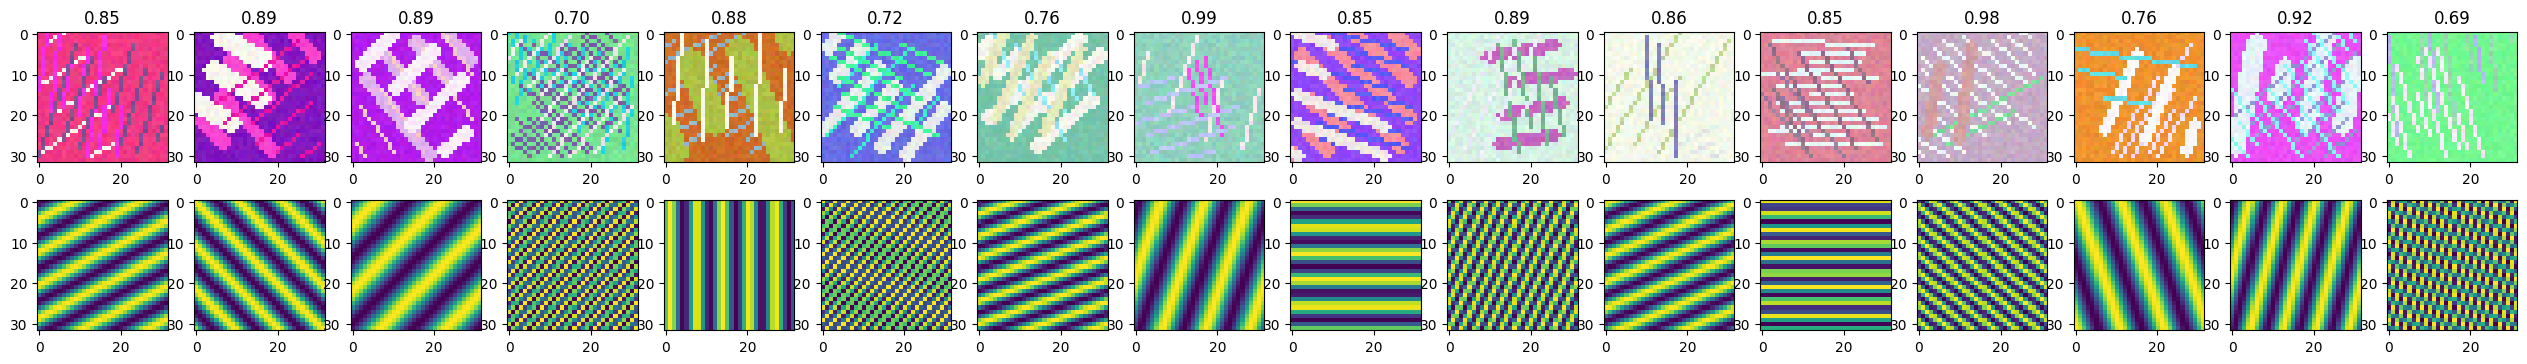

In [36]:
features, labels = next(dg.ds_iter)
I, prop_Iuvx, prop_freqs = features
print([x.shape for x in features], labels.shape)

#true_Iuvx = fd(*tf.split(true_freqs, [2,1], axis=-1))
prop_Iuvx = fd(*tf.split(prop_freqs, [2,1], axis=-1))

s = len(I)
fig, axs = plt.subplots(2, s, figsize=(s*2, 4))

for i in range(s):
    axs[0,i].imshow(I[i])
    axs[1,i].imshow(prop_Iuvx[i])
    axs[0,i].set_title('{:.2f}'.format(labels[i,0]))

## 5. Probability Model for Frequency Proposal Quality

Finally, we build a **probability model** that predicts how good a given frequency proposal is for a particular image and its line pattern.
The model uses features from the pretrained line-detection network plus frequency patches to output a scalar probability in `[0, 1]`.

In [ ]:
split_level=8
size=32
units_mult = 2

inputs = tf.keras.layers.Input((size,size,3))
freqs = tf.keras.layers.Input((size,size,1))
freqs_features = tf.keras.layers.Input((3,))

detection_model.trainable = False
inter_outputs = tf.keras.Model(detection_model.inputs, [detection_model.output, [detection_model.get_layer(f'Encoder_{i+1}').output for i in range(6)]])
mask_output, enc_outputs = inter_outputs([inputs, freqs], training=False)

f = ExtractPatches(split_level=split_level)(freqs)
f = tf.keras.layers.Reshape((split_level**2,-1))(f)
f = tf.repeat(f, 3*units_mult, axis=-1)

pos_enc = AddPosEnc()

attn_dim = f.shape[-1]

Q = FFN(mid_layers=5, mid_units=attn_dim*2, output_units=attn_dim, dropout=0.0, activation='relu', name='Q_FFN')(freqs_features)
Q = tf.keras.layers.Reshape((1,attn_dim))(Q)

for i in range(6):
    V = K = enc_outputs[i]
    K = pos_enc(K)+f

    attn_Q = MHA(attn_dim, attn_dim, attn_dim, 3*units_mult)(V,Q,K)
    Q = tf.keras.layers.Add()([Q,attn_Q])
    Q = tf.keras.layers.LayerNormalization(axis=-1)(Q)
    Q = FFN(mid_layers=4, mid_units=attn_dim*2, output_units=attn_dim, dropout=0.0, activation='relu')(Q)
    attn_Q = tf.keras.layers.Add()([Q,attn_Q])
    Q = tf.keras.layers.LayerNormalization(axis=-1)(Q)

prob_output = FFN(mid_layers=4, mid_units=attn_dim*2, output_units=1, dropout=0.2, activation='relu')(Q)
prob_output = tf.keras.layers.Reshape((1,))(prob_output)
prob_output = tf.keras.layers.Activation('sigmoid')(prob_output)


prob_model = tf.keras.Model([inputs, freqs, freqs_features], prob_output)

prob_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 extract_patches_1 (Extract  (None, 64, 16, 1)            0         ['input_5[0][0]']             
 Patches)                                                                                         
                                                                                                  
 input_6 (InputLayer)        [(None, 3)]                  0         []                      

### 5.1 Model Architecture and Attention over Frequency Patches

Key ideas:

- Reuse **encoder outputs** from the frozen detection model as high-level representations of line structure.
- Extract local **frequency patches** from the proposal frequency map via `ExtractPatches`.
- Enrich these patches with **positional encoding** to preserve spatial layout.
- Apply **multi-head attention (MHA)** between detection features (keys/values) and frequency features (queries) to learn how well each proposal aligns with observed lines.
- Aggregate attended features and project them to a **single probability output**.

This design explicitly ties the notion of "good frequency" to the actual repetitive linear content detected in the image.

In [38]:
#loss = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.75, gamma=2.) #FreqLoss(freq_weight=0.3, angle_weight=0.3, phase_weight=0.4)
loss = tf.keras.losses.MeanAbsoluteError()

prob_model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss = loss,
    metrics = [WeightedF12D(name='F1', threshold=0.85), tf.keras.metrics.Precision(name='Prec', thresholds=0.85), tf.keras.metrics.Recall(name='Rec', thresholds=0.85)]
)

In [ ]:
prob_model.fit(dg.ds, validation_data=dg.val_ds ,epochs=10, steps_per_epoch=dg.train_steps//4, validation_steps=dg.val_steps, callbacks=[
    LRCallback(warmup_lr=1e-5, warmup_epochs=0, decay_ratio=0.9)])

Epoch 1/10


96/96 [==============================] - 41s 266ms/step - loss: 0.1185 - F1: 0.5411 - Prec: 1.0000 - Rec: 0.5176 - val_loss: 0.0980 - val_F1: 0.8606 - val_Prec: 1.0000 - val_Rec: 0.7612 - lr: 0.0010
Epoch 2/10
96/96 [==============================] - 23s 238ms/step - loss: 0.0923 - F1: 0.7056 - Prec: 1.0000 - Rec: 0.5137 - val_loss: 0.0842 - val_F1: 0.8006 - val_Prec: 1.0000 - val_Rec: 0.6743 - lr: 9.0000e-04
Epoch 3/10
96/96 [==============================] - 24s 253ms/step - loss: 0.0800 - F1: 0.6958 - Prec: 1.0000 - Rec: 0.4987 - val_loss: 0.0815 - val_F1: 0.6959 - val_Prec: 1.0000 - val_Rec: 0.5400 - lr: 8.1000e-04
Epoch 4/10
96/96 [==============================] - 25s 257ms/step - loss: 0.0818 - F1: 0.6443 - Prec: 1.0000 - Rec: 0.5124 - val_loss: 0.0897 - val_F1: 0.4904 - val_Prec: 1.0000 - val_Rec: 0.3340 - lr: 7.2900e-04
Epoch 5/10
96/96 [==============================] - 25s 262ms/step - loss: 0.0803 - F1: 0.6504 - Prec: 1.0000 - Rec: 0.5111 - val_loss: 0.0747 - val_F1: 0.6642

In [ ]:
prob_model.save('./saved/single_freq_adj_binary_v1.h5')

/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 5.2 Training, Validation, and Evaluation

We train the probability model on the TFRecord dataset using:
- A regression-style loss (Mean Absolute Error on the quality score),
- Metrics such as `WeightedF12D` to capture binary decision performance if we threshold the score.

Evaluation cells visualize: 
- Input images and proposed frequency patterns,
- Ground-truth vs. predicted quality scores,
- Masks predicted by the detection model and their F1 scores.

Together, these analyses verify that the learned score correlates with **successful recognition of repetitive linear patterns**.

[TensorShape([8, 32, 32, 3]), TensorShape([8, 32, 32, 1]), TensorShape([8, 3])] [TensorShape([8, 1]), TensorShape([8, 32, 32])]
(8,)


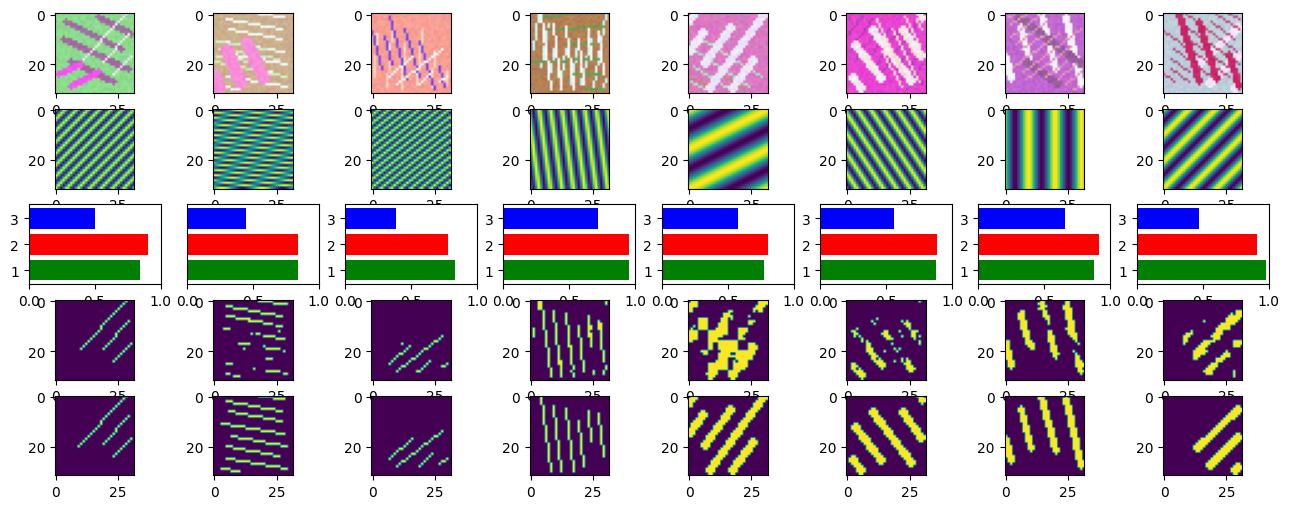

In [47]:
features, labels = next(iter(ds))
I, prop_Iuvx, prop_freqs = features
loss_labels, true_mask = labels
print([x.shape for x in features], [x.shape for x in labels])

preds = prob_model(features)
pred_mask = detection_model([I, prop_Iuvx], training=False)
F1_scores = F1(tf.reshape(true_mask, (-1, 32**2)), tf.reshape(pred_mask, (-1, 32**2)), axis=-1)
print(F1_scores.shape)

#true_Iuvx = fd(*tf.split(true_freqs, [2,1], axis=-1))
prop_Iuvx = fd(*tf.split(prop_freqs, [2,1], axis=-1))

s = len(I)
fig, axs = plt.subplots(5, s, figsize=(s*2, 6))

for i in range(s):
    axs[0,i].imshow(I[i])
    axs[1,i].imshow(prop_Iuvx[i])
    axs[2,i].barh([1],[loss_labels[i,0]], color='green')
    axs[2,i].barh([2],[preds[i,0]], color='red')
    axs[2,i].barh([3],[F1_scores[i]], color='blue')
    axs[2,i].set_xlim(0,1)
    axs[2,1].set_yticks([])
    axs[3,i].imshow(tf.where(pred_mask[i]>0.5, 1.0, 0.0))
    axs[4,i].imshow(true_mask[i])